In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

from datassist import explore
from datassist import examine_results
from datassist import log_results

### **Run Configuration**

In [2]:
# Server
START_MLFLOW_TRACKING_SERVER = False
LOG_RANDOM_FOREST_RESULTS = False
LOG_LOGISTIC_REGRESSION_RESULTS = True


# Model Training/ Evaluation
RANDOM_STATE = 42
SCORING = 'f1_weighted' # 'accuracy', 'roc_auc'

### **Preprocess Dataset**

**Load and Examine**

In [3]:
df_titanic = pd.read_csv('data/train.csv')

In [4]:
df_titanic = df_titanic.set_index('PassengerId')

In [5]:
explore.overview(df_titanic)

,NULL Count,NULL %,Unique Items,Type
Survived,0,0.0,2,int64
Pclass,0,0.0,3,int64
Name,0,0.0,891,object
Sex,0,0.0,2,object
Age,177,19.9,88,float64
SibSp,0,0.0,7,int64
Parch,0,0.0,7,int64
Ticket,0,0.0,681,object
Fare,0,0.0,248,float64
Cabin,687,77.1,147,object


In [6]:
explore.count_group(df_titanic, ['Embarked'])

,Embarked,Count
0,C,168
1,Q,77
2,S,644


**Preprocess Data**

In [7]:
null_rows = explore.find_null_rows(df_titanic, columns=['Embarked'])
null_rows

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
# preprocess the data
X_train = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket', 'Embarked'])
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())

# Split out into train set and values we want to impute
X_test = X_train.iloc[null_rows.index]
X_train = X_train.drop(null_rows.index)


In [9]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,0,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,3,1,26.0,0,0,7.9250
4,1,1,35.0,1,0,53.1000
5,3,0,35.0,0,0,8.0500


In [10]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
63,1,0,45.0,1,0,83.4750
831,3,1,15.0,1,0,14.4542


In [11]:
name2label = {'S': 0, 'C': 1, 'Q': 2}
label2name = {v: k for k, v in name2label.items()}

y_train = df_titanic['Embarked'].dropna()\
    .map(name2label).astype(int)
y_train.head()

PassengerId
1    0
2    1
3    0
4    0
5    0
Name: Embarked, dtype: int32

### **Impute missing "Embarked" values using RandomForest**

**Setup Pipeline**

In [12]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

n_items = 20
max_depth_dist = list(np.logspace(1, 3, n_items, endpoint=True).astype(int))
max_depth_dist.append(None)
param_distributions = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': np.logspace(1, 3, n_items, endpoint=True).astype(int),
    'max_depth': max_depth_dist,
}

rand_search = RandomizedSearchCV(
    clf, param_distributions, random_state=RANDOM_STATE, n_jobs=-1, n_iter=100,
    scoring=SCORING
)

**Fit**

In [13]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 12, 16, 20, 26, 33,
                                                      42, 54, 69, 88, 112, 143,
                                                      183, 233, 297, 379, 483,
                                                      615, 784, 1000, None],
                                        'n_estimators': array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])},
                   random_state=42, scoring='f1_weighted')

**Inspect Results**

Best & Average Scores

In [14]:
examine_results.print_cv_best_estimator_results(rand_search, scoring=SCORING)

Best Params:
	n_estimators: 54
	max_depth: 10
	criterion: log_loss
Best Score:
	0.822 (f1_weighted)


In [15]:
examine_results.print_mean_of_all_scores(rand_search, scoring=SCORING)

Scoring: f1_weighted
Mean Score: 0.806
Mean Std  : 0.027


Feature Importance

In [17]:
examine_results.feature_importance(
    rand_search.best_estimator_,
    feature_names=X_train.columns
)

,Feature,Importance
0,Fare,0.508774
1,Age,0.233437
2,Pclass,0.102203
3,SibSp,0.065257
4,Parch,0.049062
5,Sex,0.041268


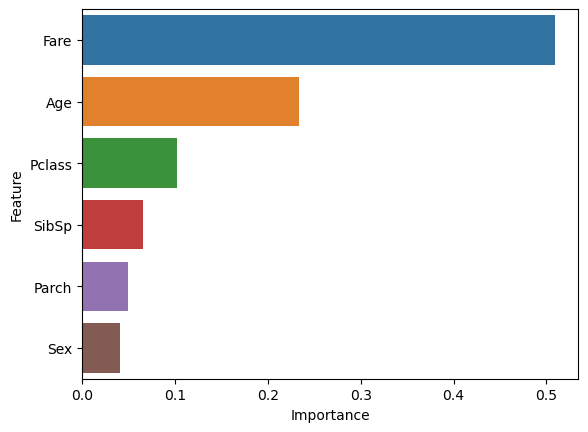

In [18]:
examine_results.plot_feature_importances(
    rand_search.best_estimator_,
    feature_names=X_train.columns
)

Predictions

In [19]:
y_pred = rand_search.predict(X_test)
pd.DataFrame(
    data={'Embarked': [label2name[l] for l in y_pred]},
    index=null_rows.index
)

,Embarked
PassengerId,
62,S
830,C


In [20]:
proba = rand_search.predict_proba(X_test)
# put into dataframe with class labels
y_classes = [label2name[i] for i in rand_search.best_estimator_.classes_]
df_proba = pd.DataFrame(data=proba, columns=y_classes, index=null_rows.index)
df_proba

,S,C,Q
PassengerId,,,
62,0.776630,0.216355,0.007015
830,0.076477,0.909737,0.013786


<Axes: >

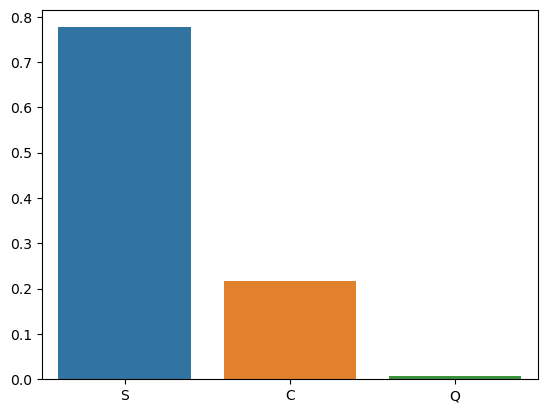

In [21]:
sns.barplot(df_proba[(df_proba.index == 62)])

<Axes: >

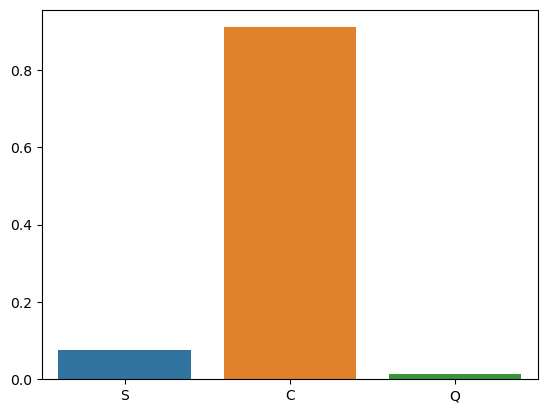

In [22]:
sns.barplot(df_proba[(df_proba.index == 830)])

**Store Model & Results**

In [23]:
if START_MLFLOW_TRACKING_SERVER:
    helper = log_results.MlflowHelper()
    helper.start_local_tracking_server()
    helper.setup_experiment('EmbarkedImpute')

In [24]:
def log_results(model, params, metrics, tags):
    return model, params, metrics, tags

In [25]:
if LOG_RANDOM_FOREST_RESULTS and START_MLFLOW_TRACKING_SERVER:
    params = rand_search.best_params_
    params['random_state'] = RANDOM_STATE

    metrics = {SCORING: rand_search.best_score_}

    tags = {'Prediction': f'{label2name[y_pred[0]]}{label2name[y_pred[1]]}'}

    helper.run_experiment(
        lambda: log_results(rand_search.best_estimator_, params, metrics, tags)
    )

### **Impute missing values using KNN Imputer**

In [26]:
imputer = KNNImputer(n_neighbors=3)
X_knn = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
X_knn['Sex'] = X_knn['Sex'].map({'male': 0, 'female': 1}).astype(int)
X_knn['Age'] = X_knn['Age'].fillna(X_knn['Age'].median())
X_knn['Embarked'] = X_knn['Embarked'].fillna('U').map(name2label)
X_imputed = imputer.fit_transform(X_knn)
X_imputed = pd.DataFrame(
    data=X_imputed,
    columns=X_knn.columns,
    index=X_knn.index
)
X_imputed.loc[null_rows.index]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
62,1.0,1.0,38.0,0.0,0.0,80.0,0.333333
830,1.0,1.0,62.0,0.0,0.0,80.0,0.666667


KNNImputer doesn't seem to produce integer values, and I'm not sure how to interpret the results.

### **Impute missing values using Logistic Regression**

**Setup Pipeline**

In [27]:
scaler = QuantileTransformer(
    n_quantiles=500,
    output_distribution='normal',
    random_state=RANDOM_STATE
)

clf = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE, n_jobs=-1
)

param_grid = [
    {
        'solver':['newton-cg', 'lbfgs', 'sag'],
        'penalty': [None, 'l2'],
        'class_weight': [None, 'balanced'],
    },
    {
        'solver': ['saga'],
        'penalty': [None, 'l2', 'l1'],
        'class_weight': [None, 'balanced'],
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': np.arange(0.1, 1, 0.1),
        'class_weight': [None, 'balanced'],
    },
]

grid_search = GridSearchCV(
        clf, param_grid, scoring=SCORING, n_jobs=-1
)

pipe = Pipeline([
        ('scaling', scaler),
        ('grid_search', grid_search)
    ])

**Fit**

In [28]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaling',
                 QuantileTransformer(n_quantiles=500,
                                     output_distribution='normal',
                                     random_state=42)),
                ('grid_search',
                 GridSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=42),
                              n_jobs=-1,
                              param_grid=[{'class_weight': [None, 'balanced'],
                                           'penalty': [None, 'l2'],
                                           'solver': ['newton-cg', 'lbfgs',
                                                      'sag']},
                                          {'class_weight': [None, 'balanced'],
                                           'penalty': [None, 'l2', 'l1'],
                                           'solver': ['saga']},
                                          {'class_weight': [None, 'balanced'],
                                           'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                           'penalty': ['elasticnet'],
                                           'solver': ['saga']}],
                              scoring='f1_weighted'))])

**Inspect Results**

Best & Average Results

In [29]:
examine_results.print_cv_best_estimator_results(pipe, scoring=SCORING)

Best Params:
	class_weight: None
	penalty: l1
	solver: saga
Best Score:
	0.615 (f1_weighted)


In [30]:
examine_results.print_mean_of_all_scores(pipe, scoring=SCORING)

Scoring: f1_weighted
Mean Score: 0.499
Mean Std  : 0.050


Feature Importance

In [31]:
examine_results.feature_importance(
    pipe,
    feature_names=X_train.columns
)

,Feature,Importance
0,Parch,0.038561
1,Pclass,0.000000
2,Age,0.000000
3,SibSp,0.000000
4,Fare,0.000000
5,Sex,-0.029477


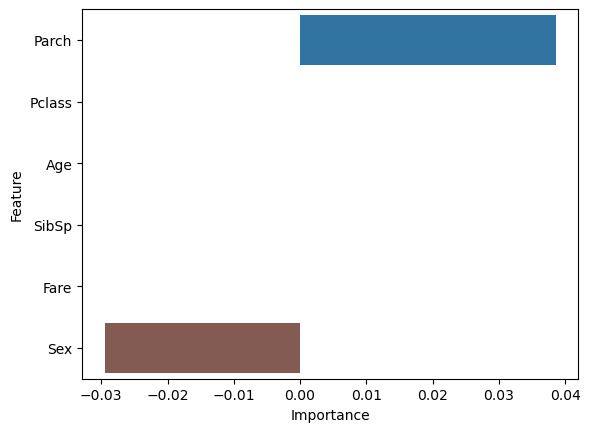

In [32]:
examine_results.plot_feature_importances(
    pipe,
    feature_names=X_train.columns
)

Predictions

In [33]:
y_pred = pipe.predict(X_test)
pd.DataFrame(
    data={'Embarked': [label2name[l] for l in y_pred]},
    index=null_rows.index
)

,Embarked
PassengerId,
62,S
830,S


In [34]:
proba = grid_search.predict_proba(X_test)
y_classes = [label2name[i] for i in grid_search.best_estimator_.classes_]
df_proba = pd.DataFrame(data=proba, columns=y_classes, index=null_rows.index)
df_proba

c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,S,C,Q
PassengerId,,,
62,3.304794e-07,1.000000,1.060053e-10
830,4.672582e-01,0.476369,5.637318e-02


<Axes: >

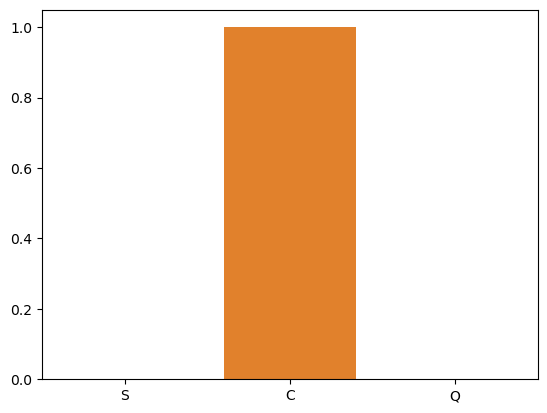

In [35]:
sns.barplot(df_proba[(df_proba.index == 62)])

<Axes: >

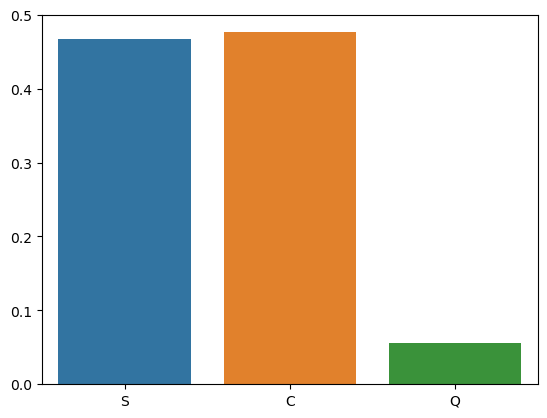

In [36]:
sns.barplot(df_proba[(df_proba.index == 830)])

I'm not convinced that the logistic regression model is able to linearly separate the classes. The importance of each feature has a magnitude < 0.04 which is strange compared to the random forrest model, which ranks each feature nicely.

The random forrest model also has a better F1 and accuracy score, so seems more reliable.

**Store Model & Results**

In [37]:
if LOG_LOGISTIC_REGRESSION_RESULTS and START_MLFLOW_TRACKING_SERVER:
    params = grid_search.best_params_
    params['random_state'] = RANDOM_STATE

    metrics = {SCORING: grid_search.best_score_}

    tags = {'Prediction': f'{label2name[y_pred[0]]}{label2name[y_pred[1]]}'}

    helper.run_experiment(
        lambda: log_results(grid_search.best_estimator_, params, metrics, tags)
    )